In [165]:
import glob, os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import statistics
import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = r"Gutenberg/test1/"
DATABASE_USER = 'root'
DATABASE_USER_PASSWORD = 'password'
DATABASE_HOST = 'localhost'
DATABASE_NAME = 'Authorship_Attribution'
DATABASE_TABLE = 'author1'
DATABASE_CONNECTION = "mysql+pymysql://" + DATABASE_USER + ":" + DATABASE_USER_PASSWORD + "@" + DATABASE_HOST + "/" + DATABASE_NAME


def pre_processing():
    author, file_path = get_author_and_file_path()
    authors, text = get_authors_and_text_list(author, file_path)
    return authors, text


def get_author_and_file_path():
    author, text = [], []
    for file in glob.glob(f"{DATA_DIR}*.txt"):
        author.append(file.split("/")[-1].split("__")[0])
        text.append(file)
    return author, text


def get_authors_and_text_list(author, file_path):
    authors, text = [], []
    for auth, file in zip(author, file_path):
        name, sentence = get_author_and_text(auth, file)
        authors.extend(name)
        text.extend(sentence)
    return authors, text


def get_author_and_text(author, file):
    authors, text = [], []
    with open(file, encoding='utf-8') as f:
        data = f.read()

    data = data.strip()
    data = data.split("\n\n")
    for para in data:
        authors.append(author)
        para = para.replace("\n", "")
        text.append(para)
    return authors, text


def get_features(paragraph):
    feature_set = []
    unique_word = set()
    stop_words = 0
    commas = 0
    special_char = 0
    uppercase = 0
    articles = 0
    nouns = 0
    verbs = 0
    pronouns = 0

    token_word = nltk.word_tokenize(paragraph)
    tagged_word = nltk.pos_tag(token_word)

    para = (len(paragraph))
    sent = paragraph.count('.')
    sent_max_len = len(max(paragraph.split('.')))
    words = (len(token_word))

    for word, tag in tagged_word:
        if word not in unique_word and tag not in ('AT', 'DT') and \
                word not in stopwords.words('english') and word not in string.punctuation:
            unique_word.add(word)
        if word in stopwords.words('english'):
            stop_words += 1
        if word in string.punctuation:
            if word == ',':
                commas += 1
            else:
                special_char += 1
        if word.isupper():
            uppercase += 1
            # if tag in ('AT', 'DT'):
            #     articles += 1
            # if tag in ('NNP', 'NOUN'):
            #     nouns += 1
            # if tag in ('VBD', 'VERB'):
            #     verbs += 1
            # if tag in ('PRP', 'PRON'):
            #     pronouns += 1

    feature_set.append(para)
    feature_set.append(sent)
    feature_set.append(sent_max_len)
    feature_set.append(words)
    feature_set.append(len(unique_word))
    feature_set.append(stop_words)
    feature_set.append(commas)
    feature_set.append(special_char)
    feature_set.append(uppercase)
    #     feature_set.append(articles)
    #     feature_set.append(nouns)
    #     feature_set.append(verbs)
    #     feature_set.append(pronouns)
    return feature_set


def connect_to_database():
    engine = create_engine(DATABASE_CONNECTION)
    return engine


def disconnect_to_database(engine):
    engine.dispose()


def write_to_database(engine, df):
    df.to_sql(con=engine, name=DATABASE_TABLE, if_exists='replace', chunksize=5000)


def read_from_database(engine):
    df1 = pd.DataFrame()
    df1 = pd.read_sql('SELECT * FROM author1', con=engine)
    return df1


In [166]:
def naive_bayes(X_train, y_train, X_test, y_test, classes):
    gnb = MultinomialNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print(f"Naive Bayes - Accuracy: {100 * accuracy_score(y_test, y_pred):2.4f}%")
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(cnf_matrix)

    np.set_printoptions(precision=2)
    plt.figure(figsize=(8, 6))
    display = plot_confusion_matrix(gnb, X_test, y_test, display_labels=classes, cmap=plt.cm.Blues, normalize='true')
    display.ax_.set_title('Confusion matrix')
    plt.show()

In [167]:
def kmeans_print_optimal_k(X):
    wass = []
    for i in range(1, 11):
        KM = KMeans(init='k-means++', n_clusters=i, max_iter=500)
        KM.fit(X)
        wass.append(KM.inertia_)

    plt.plot(range(1, 11), wass, color='green', linewidth='3')
    plt.xlabel("K")
    plt.ylabel("Sqaured Error (wass)")
    plt.figure(figsize=(15, 15))
    plt.show()


def kmeans(X, y):
    # print no of optimal K
    kmeans_print_optimal_k(X)

    X = X.to_numpy()
    kmeans = KMeans(init='k-means++', n_clusters=6)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=100, cmap='viridis')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, alpha=0.5)
    plt.figure(figsize=(15, 15))
    plt.show()


def kmeans_pairwise_comparison(df):
    sns.pairplot(data=df, hue="authors")

In [168]:
def kmeans_print_accuracy(y_actual, y_predict, kmeans_type):
    accuracy_count = 0
    print(y_actual)
    print(y_predict)
    for i in range(len(y_actual)):
        if y_actual[i] == y_predict[i]:
            accuracy_count += 1
    print(f"K-Means - {kmeans_type} Accuracy: {100 * accuracy_count / len(y_actual):2.4f}%")


def kmeans_classification(X, y):
    X = X.to_numpy()
    labelEncoder = LabelEncoder()
    y_encoded = labelEncoder.fit_transform(y)
    #     X_actual = X
    X_actual, y_actual = shuffle(X, y_encoded, random_state=0)

    kmeans = KMeans(init='k-means++', n_clusters=6)
    kmeans.fit(X_actual)
    y_kmeans = kmeans.predict(X_actual)
    kmeans_print_accuracy(y_actual, y_kmeans, 'Standard')

    # max scaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans.fit(X_scaled)
    y_scaled = kmeans.predict(X_scaled)
    kmeans_print_accuracy(y_actual, y_scaled, 'With Scaling')

    # PCA
    pca = PCA(n_components=7)
    X_pca = pca.fit_transform(X)
    kmeans.fit(X_pca)
    y_pca = kmeans.predict(X_pca)
    kmeans_print_accuracy(y_actual, y_pca, 'With PCA')

Accuracy: 47.6883%
[[  10   10   56   86    0   36]
 [  48   58   71  121    1  216]
 [  24   21  214   82    0   18]
 [  22   35  285 1147    0  146]
 [  11   29   66   93    0   57]
 [   6   15   21   41    1   46]]


<Figure size 576x432 with 0 Axes>

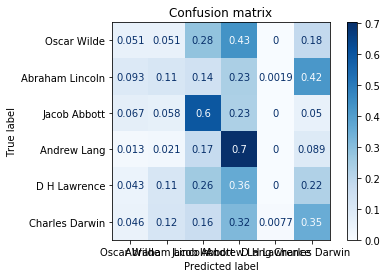

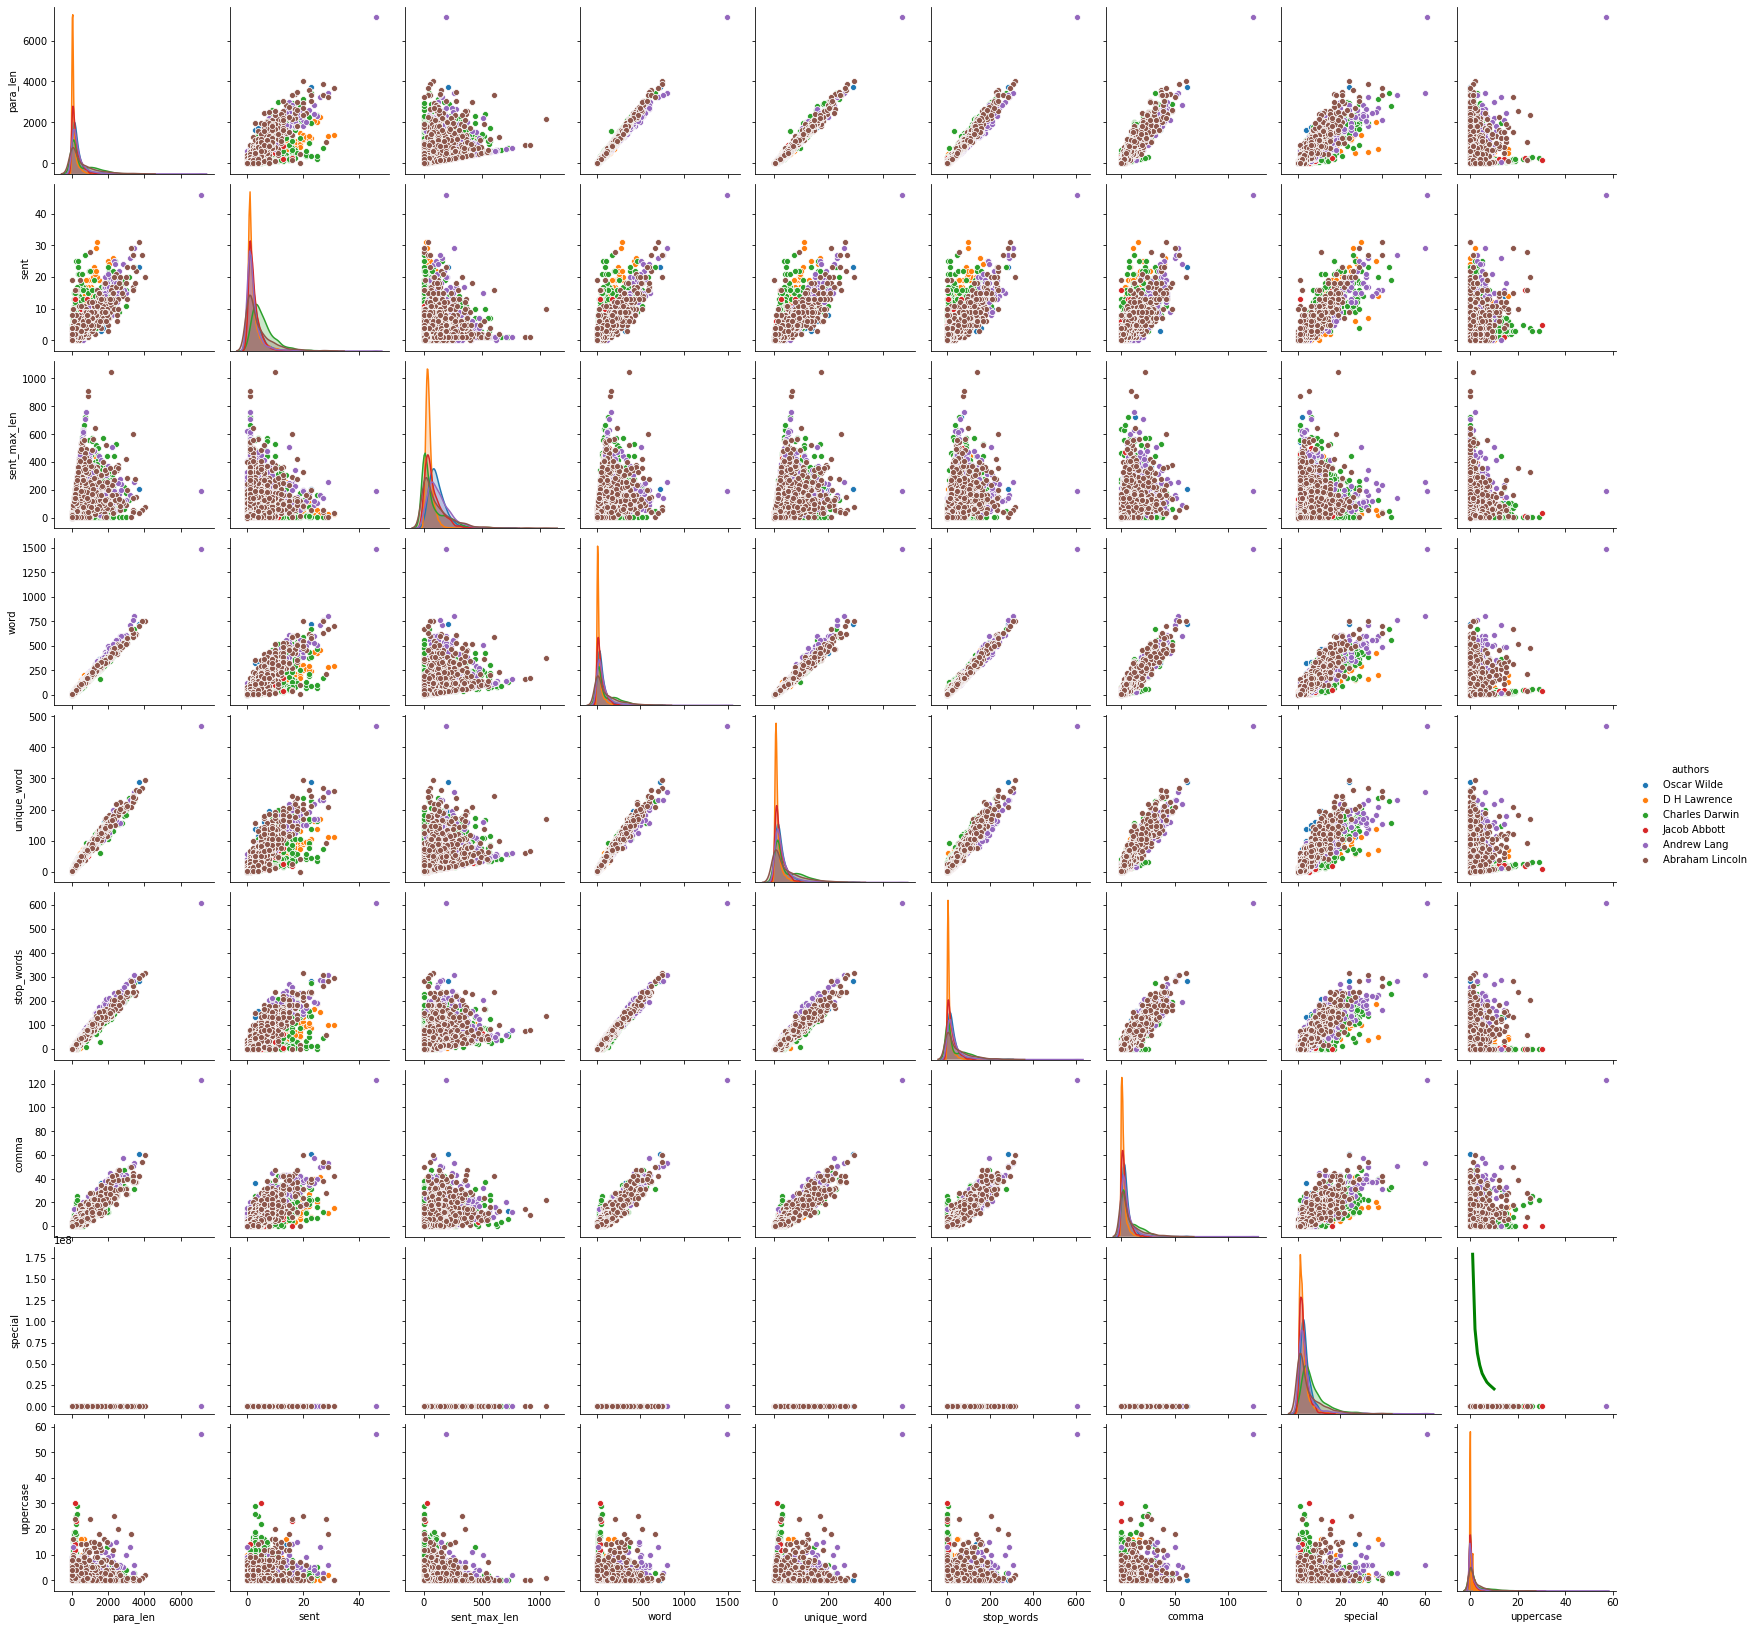

<Figure size 1080x1080 with 0 Axes>

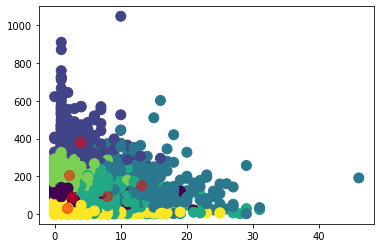

<Figure size 1080x1080 with 0 Axes>

[0 3 3 ... 1 1 3]
[2 5 5 ... 1 1 5]
Accuracy: 11.3105%
[0 3 3 ... 1 1 3]
[3 4 0 ... 1 1 1]
Accuracy: 18.4493%
[0 3 3 ... 1 1 3]
[0 4 5 ... 3 3 3]
Accuracy: 34.4329%


In [169]:
authors, sentences = pre_processing()
df = pd.DataFrame()
df['authors'], df['sentences'] = authors, sentences
classes = list(set(authors))
del authors
del sentences

# Get all features
df['features'] = df['sentences'].apply(lambda sentence: get_features(sentence))
df[['para_len', 'sent', 'sent_max_len', 'word', 'unique_word', 'stop_words', 'comma', 'special', 'uppercase']] = \
    pd.DataFrame(df.features.values.tolist(), index=df.index)
del df['features']

# Write to DB
# connection = connect_to_database()
# write_to_database(connection, df)

# Read from DB
# df1 = pd.DataFrame()
# df1 = read_from_database(connection)

# X, y and split
X, y = df.iloc[:, 3:], df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Naive Bayes
naive_bayes(X_train, y_train, X_test, y_test, classes)
# K-Means pairwise
kmeans_pairwise_comparison(df)
# K-Means clustering
kmeans(X, y)
# K-Means classification
kmeans_classification(X, y)